<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/bkitano/Llama_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference Brian Kitano Blog](https://blog.briankitano.com/llama-from-scratch/)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-11-03 06:42:42--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-11-03 06:42:43 (18.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
with open('input.txt',"r") as f:
    lines = f.read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i,ch in enumerate(vocab)}
stoi = {ch:i for i,ch in itos.items()}

print(lines[:30])

First Citizen:
Before we proce


In [5]:
def encode(s):
    return [stoi[ch] for ch in s]
def decode(l):
    return "".join([itos[i] for i in l])

print("vocab size",len(vocab))
decode(encode("hello"))

vocab size 65


'hello'

In [6]:
MASTER_CONFIG = {
    "vocab_size":len(vocab)
}

In [7]:
dataset = torch.tensor(encode(lines),dtype=torch.uint8)
print(dataset.shape)

torch.Size([1115394])


generate batches

In [51]:
def get_batches(data,split,batch_size,context_window,config = MASTER_CONFIG):
    train = data[:int(0.8*len(data))]
    val  = data[int(0.8 * len(data)):int(0.9 * len(data))]
    test = data[int(0.9* len(data)):]

    batch_data = train
    if split == "test":
        batch_data = test

    if split == "val":
        batch_data = val
    #picking random starting points
    ix = torch.randint(0,batch_data.size(0)-context_window-1,(batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+1+context_window] for i in ix]).long()
    return x,y

MASTER_CONFIG.update({
    "batch_size":8,
    "context_window":16
})
xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
[(decode(xs[i].tolist()),decode(ys[i].tolist()))for i in range(len(xs))]

[('us arms pluck hi', 's arms pluck him'),
 ('\nBALTHASAR:\nI br', 'BALTHASAR:\nI bro'),
 ('all to death:\nTh', 'll to death:\nTha'),
 (':\nHis prayers ar', '\nHis prayers are'),
 ("WARWICK:\n'Twas n", "ARWICK:\n'Twas no"),
 ('spute with thee ', 'pute with thee o'),
 ('h him.\n\nKING HEN', ' him.\n\nKING HENR'),
 ('rd,\nWhich hoxes ', 'd,\nWhich hoxes h')]

In [9]:
@torch.no_grad() #dont compute gradients for this function
def evaluate_loss(model,config = MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train","val"]:
        losses = []
        for _ in range(10):
            xs,ys = get_batches(dataset,split,MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
            _,loss = model(xs,ys)
            losses.append(loss)
        out[split] = np.mean(losses)
    model.train()
    return out


In [10]:
class SimpleBrokenModel(nn.Module):
    def __init__(self,config = MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config['d_model']),
            nn.ReLU(),
            nn.Linear(config["d_model"],config["vocab_size"])
        )
        print("model params", sum(m.numel() for m in self.parameters()))

    def forward(self,idx,targets = None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a,dim=-1)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config['vocab_size']),targets.view(-1))
            return logits,loss
        else:
            return logits
MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)


model params 33217


model params 33217
validation loss:  3.9397464


<Axes: >

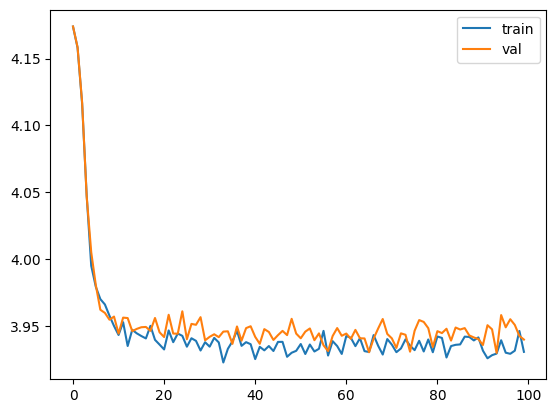

In [11]:
MASTER_CONFIG.update({
    "epochs":1000,
    "log_interval":10,
    "batch_size":32
})
model = SimpleBrokenModel(MASTER_CONFIG)
optimizer = torch.optim.Adam(model.parameters())

def train(model,optimizer,scheduler = None,config = MASTER_CONFIG,print_logs = False):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
        logits,loss = model(xs,ys)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        if epoch % config["log_interval"] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()
            if scheduler:
                print(f"lr :{scheduler.get_lr()}")
    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()
train(model, optimizer)

model params,33217
validation loss:  2.5017412


<Axes: >

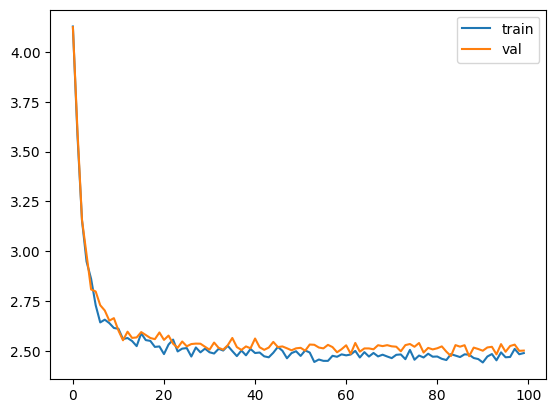

In [12]:
class SimpleModel(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"],config['vocab_size'])
        )
        print(f"model params,{sum(m.numel() for m in self.parameters())}")
    def forward(self,idx,targets = None):
        x = self.embedding(idx)
        logits = self.linear(x)
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
# xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
# logits,loss = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer)

In [13]:
def generator(model,config= MASTER_CONFIG,max_new_tokens = 30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence

    return [decode(x) for x in idx.tolist()]

generator(model)

['\nTESen,\nWit Juthrn alino f mmee',
 "\nMOUTHAnay dald.\nYowen'sea ower",
 '\nBe mlice olfathe mbu omelf be ',
 '\nGHarsthy,\nI nen shis\nHe atebet',
 '\n\nCod ofon hesh whamy ts se ate']

# Llama specifics

Llama describes three architectural modifications to the original Transformer:



1.   RMSNorm for pre-normalization
2.   Rotary embeddings
3.   SwiGLU activation function






# [RMSNorm(Root Mean Square Layer Norm)](https://arxiv.org/pdf/1910.07467.pdf)

> which is where you scale the vector by the variance without centering it
 In addition, while Vaswani applies normalization to the output of the attention layer (post-normalization), Llama applies it to the inputs before (pre-normalization).

In [14]:
class RMSNormSimple(nn.Module):
    def __init__(self,layer_shape,eps = 1e-8,bias = False):
        super(RMSNormSimple,self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(layer_shape))
    def forward(self,x):
        """
        assumes shape is (batch ,seq_len,d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        # ff_rms = torch.linalg.norm(x,dim=(1,2)) * x[0].numel() ** -0.5
        ms = x.pow(2).mean(-1,keepdims = True) # (B,T,1)
        norm = torch.rsqrt(ms+self.eps) #(B,T,1)
        out = x * norm # (B,T,d_model)

        out = out * self.weight

        return out

config = {
    "batch_size":5,
    "context_window":11,
    "d_model":13
}
batch = torch.randn((config["batch_size"],config["context_window"],config["d_model"]))
m = RMSNormSimple((config["context_window"],config["d_model"]))
g = m(batch)


In [15]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    "batch_size":5,
    "context_window":11,
    "d_model":13
}
batch = torch.randn((config["batch_size"],config["context_window"],config["d_model"]))
m = RMSNorm((config["context_window"],config["d_model"]))
g = m(batch)


test rms norm

In [16]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)
#scaled_batch.dim(1,2)
assert torch.linalg.norm(torch.arange(5).float()) == torch.sqrt(torch.sum(torch.arange(5).float()**2))
rms = torch.linalg.norm(torch.arange(5).float()) * (torch.arange(5).numel() ** -0.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5
#RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]

assert torch.allclose(torch.linalg.norm(ffx,dim=(1,2))**2,torch.tensor(143).float())
assert torch.allclose(g,ffx)

model params 35265
validation loss:  2.4923968


<Axes: >

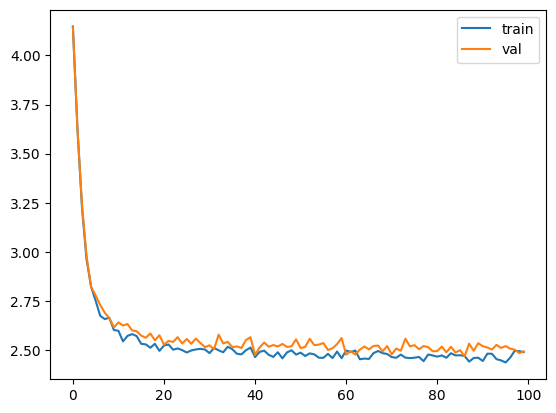

In [17]:
class SimpleModel_RMS(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
        self.rms = RMSNorm((config["context_window"],config["d_model"]))
        #self.rms = RMSNormSimple((config["context_window"],config["d_model"]))
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"],config["vocab_size"])
        )
        print(f"model params {sum([m.numel() for m in self.parameters()])}")
    def forward(self,idx,targets= None):
        x = self.embedding(idx)
        x = self.rms(x)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
        else:
            return logits

model = SimpleModel_RMS(config=MASTER_CONFIG)
xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG['context_window'])
loss,logits = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer)

RoPE(Rotary Position EMbedding)
> from the [RoFormer Paper](https://arxiv.org/pdf/2104.09864.pdf)

In [18]:
def get_rotary_matrix(context_window,embedding_dim):
    R = torch.zeros((context_window,embedding_dim,embedding_dim))
    for position in range(context_window):
        for i in range(0,embedding_dim // 2):
            theta = 10000 ** (-2*(i-1))/embedding_dim
            m_theta = position * theta
            R[position,2*i,2*i] = np.cos(m_theta)
            R[position,2*i,2*i+1] = - np.sin(m_theta)
            R[position,2*i+1,2*i] = np.sin(m_theta)
            R[position,2*i+1,2*i+1] = np.cos(m_theta)
    return R

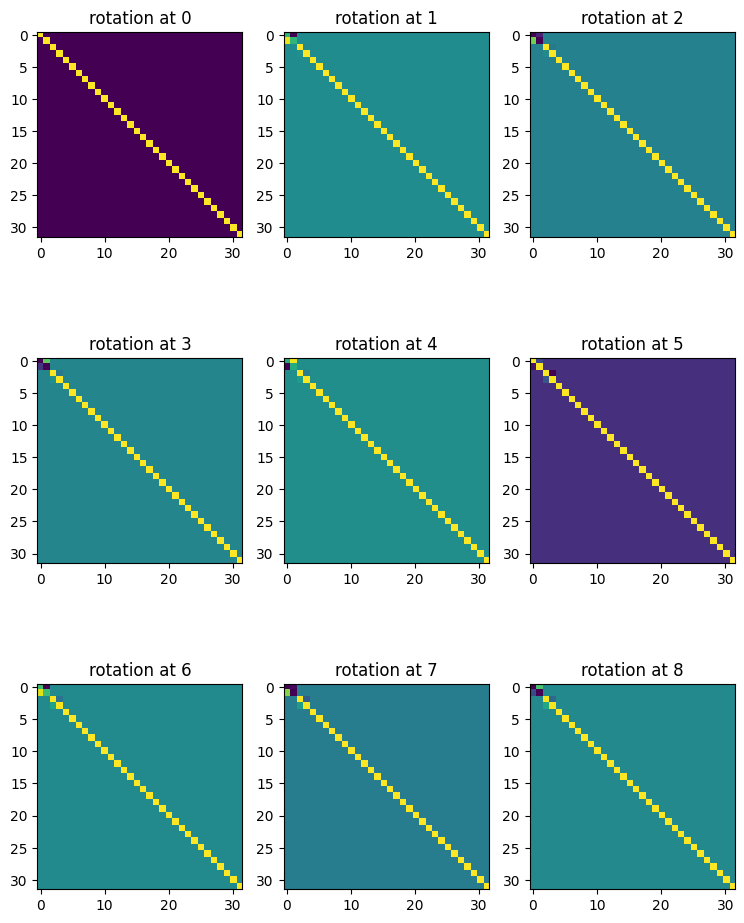

In [19]:
K = 3
config = {
    "batch_size":10,
    "d_model":32,
    "n_heads":8,
    "context_window":K**2
}
batch = torch.randn(1,config["context_window"],config["d_model"])
R = get_rotary_matrix(config["context_window"],config["d_model"])
fig,ax = plt.subplots(K,K,figsize=(K*3,K*4))
for i in range(K):
    for j in range(K):
        ax[i,j].imshow(R[i*K+j,:,:].detach().numpy())
        ax[i,j].set_title(f"rotation at {i*K + j}")

make sure it works right

In [20]:
config = {
    "d_model":128,
    "context_window":16,

}
R  = get_rotary_matrix(config["context_window"],config["d_model"])
x = torch.randn(config["d_model"])
y = torch.randn(config["d_model"])
m = 3
n = 13
x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y
assert torch.isclose(x_m @ x_n,x @ R[n-m,:,:] @y)
#RoPE works as expected

In [21]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}
class RopeAttentionHead(nn.Module):
    def __init__(self,config):
        super(RopeAttentionHead,self).__init__()

        self.config = config

        self.W_q = nn.Linear(config["d_model"],config["d_model"],bias = False)
        self.W_k = nn.Linear(config["d_model"],config["d_model"],bias = False)
        self.W_v = nn.Linear(config["d_model"],config["d_model"],bias = False)

        self.R = self.get_rotary_matrix(config["context_window"],config["d_model"])

    def get_rotary_matrix(self,context_window,embedding_dim):
        R = torch.zeros((context_window,embedding_dim,embedding_dim),requires_grad = False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000 ** (-2 *(i - 1)/embedding_dim)
                m_theta = position * theta
                R[position,2*i,2*i] = np.cos(m_theta)
                R[position,2*i,2* i + 1] = - np.sin(m_theta)
                R[position,2*i+1,2*i] = np.sin(m_theta)
                R[position,2*i+1,2*i+1] = np.cos(m_theta)
        return R
    def forward(self,x,return_attention_weights = False):
        b,m,d = x.shape

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q_rotated = torch.bmm(q.transpose(0,1),self.R[:m]).transpose(0,1)
        k_rotated = torch.bmm(k.transpose(0,1),self.R[:m]).transpose(0,1)

        activations = F.scaled_dot_product_attention(q_rotated,k_rotated,v,dropout_p= 0.1)

        if return_attention_weights:
            attn_weights = torch.bmm(q_rotated,k_rotated.transpose(1,2)) / np.sqrt(d)
            attn_weights = F.softmax(attn_weights,dim= -1)
            return activations,attn_weights
        return activations
layer = RopeAttentionHead(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output,attn_weights = layer(batch,return_attention_weights=True)

test if it works as intended

In [22]:
x = torch.rand(config["batch_size"],config["context_window"],config["d_model"])
q = layer.W_q(x)
k = layer.W_k(x)
v = layer.W_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config["context_window"]):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:],layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:],layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:],layer.R[position,:,:])
q_rotated_1 = torch.bmm(q.transpose(0,1),layer.R).transpose(0,1)
k_rotated_1 = torch.bmm(k.transpose(0,1),layer.R).transpose(0,1)
v_rotated_1 = torch.bmm(v.transpose(0,1),layer.R).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0],q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0],q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated,q_rotated_1)

In [23]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}
layer = RopeAttentionHead(config)
batch = torch.ones((config["batch_size"],config["context_window"],config["d_model"]))
output,attn_weights = layer(batch,return_attention_weights = True)

m = 0
x_q = batch[0,m]
q = layer.R[m,:,:] @ layer.W_q(x_q)

assert torch.allclose(layer.W_q(x_q),layer.W_q.weight @ x_q)
assert torch.allclose(q,layer.R[m,:,:]@ layer.W_q.weight @ x_q)

n = 2
x_k = batch[0,n]
k = layer.R[n,:,:] @ layer.W_k(x_k)

assert torch.allclose(layer.W_k(x_k),layer.W_k.weight @ x_k)
assert torch.allclose(k,layer.R[n,:,:] @ layer.W_k.weight @ x_k)

assert q.T @ k == q @ k #transpose is redundant
assert torch.allclose(q @ k,x_k.T @ layer.W_k.weight.T @ layer.R[n,:,:].T @ layer.R[m,:,:] @ layer.W_q.weight @ x_q)
assert torch.allclose(q @ k,x_k.T @ layer.W_k.weight.T @ layer.R[n-m,:,:].T @ layer.W_q.weight @ x_q)

<ipython-input-23-13f0a9842aea>:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  assert q.T @ k == q @ k #transpose is redundant


# MultiheadedAttention Model

In [24]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 3,
    'context_window': 3,
}
class RoPEMultiHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RopeAttentionHead(config) for _ in range(config["n_heads"])
        ])
        self.linear = nn.Linear(config["n_heads"] * config["d_model"],config["d_model"])
        self.dropout = nn.Dropout(0.1)
    def forward(self,x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads,dim = -1)
        x = self.linear(x)
        x = self.dropout(x)
        return x
MASTER_CONFIG.update({
    "n_heads":8
})
layer = RoPEMultiHeadAttention(MASTER_CONFIG)
batch = torch.ones(MASTER_CONFIG["batch_size"],MASTER_CONFIG['context_window'],MASTER_CONFIG["d_model"])
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params : 559681
Epoch 0 | val loss 4.042 | Time 0.093 | ETA in seconds 0.929
Epoch 100 | val loss 0.577 | Time 7.046 | ETA in seconds 63.418
Epoch 200 | val loss 0.326 | Time 7.859 | ETA in seconds 62.869
Epoch 300 | val loss 0.214 | Time 6.404 | ETA in seconds 44.828
Epoch 400 | val loss 0.182 | Time 7.275 | ETA in seconds 43.652
Epoch 500 | val loss 0.170 | Time 7.714 | ETA in seconds 38.570
Epoch 600 | val loss 0.165 | Time 7.235 | ETA in seconds 28.942
Epoch 700 | val loss 0.157 | Time 7.031 | ETA in seconds 21.094
Epoch 800 | val loss 0.164 | Time 6.362 | ETA in seconds 12.724
Epoch 900 | val loss 0.162 | Time 7.213 | ETA in seconds 7.213
validation loss:  0.16170125


<Axes: >

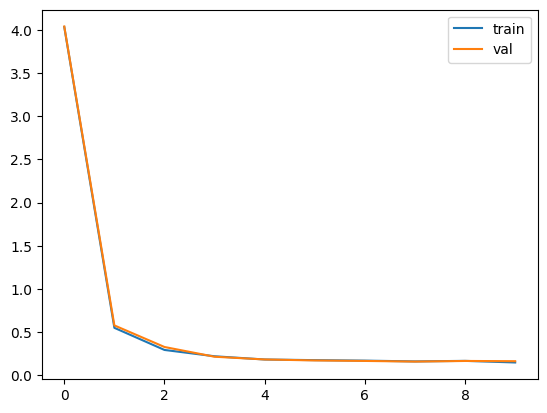

In [25]:
class RoPEModel(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config
        self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
        self.rms = RMSNorm((config["context_window"],config["d_model"]))
        self.rope_attention = RoPEMultiHeadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            nn.ReLU()
        )
        self.last_linear = nn.Linear(config["d_model"],config["vocab_size"])
        print(f"model params : {sum([m.numel() for m in self.parameters()])}")
    def forward(self,idx,targets = None):
        x = self.embedding(idx)
        #one attention block
        x = self.rms(x) # rms prenormalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms prenormalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
        else:
            return logits
MASTER_CONFIG.update({
    "log_interval":100
})
model = RoPEModel(MASTER_CONFIG)
xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
logits,loss = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer,print_logs = True)

In [26]:
generator(model, config=MASTER_CONFIG)

['\n\n\n\n\n\n\nOOOOOOOOOOOOOOOOOOOOOOOO',
 '\n\n\nAUUEEEEEEEEEEEEEEEEEEEEEEEEE',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\nOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 '\n\nIIIIIIIIIIIIIIIIIIIIIIIIIIIII']

This result looks terrible.Lets debug attention

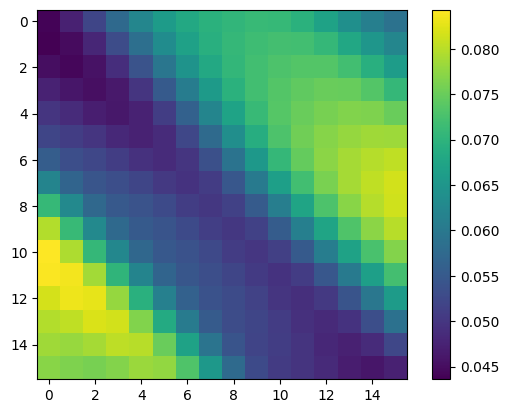

In [27]:
MASTER_CONFIG.update({
    "n_heads":8
})
layer = RopeAttentionHead(MASTER_CONFIG)
batch = torch.ones(MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"],MASTER_CONFIG["d_model"])
output,attn_weights = layer(batch,return_attention_weights = True)

plt.imshow(attn_weights[0].detach().numpy(),interpolation = 'nearest')
plt.colorbar()

So here we see that all the attention is lit up, meaning that characters in any position are attending to characters in any other position. What's bad about this? We are trying to predict the next token solely on the tokens that came before it, but here we're seeing that the model is attending to tokens that come after it. In other words, the model is cheating, or leaking information from the future. This is a problem, and it's why we need to use a causal mask.

In [28]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config
        self.w_q = nn.Linear(config["d_model"],config["d_model"],bias = False)
        self.w_k = nn.Linear(config["d_model"],config["d_model"],bias = False)
        self.w_v = nn.Linear(config["d_model"],config["d_model"],bias = False)

        self.R = self.get_rotary_matrix(config["context_window"],config["d_model"])
    def get_rotary_matrix(self,context_window,embedding_dim):
        R = torch.zeros((context_window,embedding_dim,embedding_dim),requires_grad = False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000 ** (-2 *(i - 1)/embedding_dim)
                m_theta = position * theta
                R[position,2*i,2*i] = np.cos(m_theta)
                R[position,2*i,2* i + 1] = - np.sin(m_theta)
                R[position,2*i+1,2*i] = np.sin(m_theta)
                R[position,2*i+1,2*i+1] = np.cos(m_theta)
        return R
    def forward(self,x,return_attention_weights = False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = torch.bmm(q.transpose(0,1),self.R[:m]).transpose(0,1)
        k_rotated = torch.bmm(k.transpose(0,1),self.R[:m]).transpose(0,1)

        activations = F.scaled_dot_product_attention(q_rotated,k_rotated,v,dropout_p=0.1,is_causal=True)
        if return_attention_weights:
            attn_mask = torch.tril(torch.ones((m,m)),diagonal = 0)
            attn_weights = torch.bmm(q_rotated,k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights,dim = -1)
            return activations,attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn((config["batch_size"],config["context_window"],config["d_model"]))
output,attn_weights = layer(batch,return_attention_weights = True)

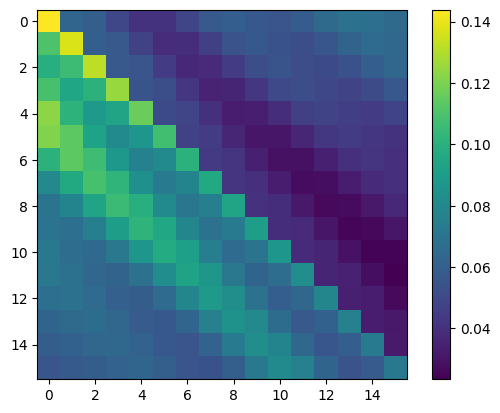

In [29]:
layer = RoPEMaskedAttentionHead(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attention_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

Now, we can see that the upper triangular of our attention activations (the part that corresponds to the future) is nearly zeroed out. Let's see what happens when we train.

In [30]:
class RoPEMaskedMultiHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config["n_heads"])
        ])
        self.linear = nn.Linear(config["n_heads"]* config["d_model"],config["d_model"])
        self.dropout = nn.Dropout(0.1)

    def forward(self,x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads,dim= -1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

MASTER_CONFIG.update({
    "n_heads":8
})
layer = RoPEMaskedMultiHeadAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"],MASTER_CONFIG["d_model"]))
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

model params,559681
Epoch 0 | val loss 4.116 | Time 0.112 | ETA in seconds 1.122
Epoch 500 | val loss 2.166 | Time 33.712 | ETA in seconds 303.409
Epoch 1000 | val loss 2.096 | Time 34.485 | ETA in seconds 275.876
Epoch 1500 | val loss 2.069 | Time 34.764 | ETA in seconds 243.346
Epoch 2000 | val loss 2.035 | Time 47.124 | ETA in seconds 282.743
Epoch 2500 | val loss 1.983 | Time 40.755 | ETA in seconds 203.776
Epoch 3000 | val loss 2.040 | Time 36.883 | ETA in seconds 147.532
Epoch 3500 | val loss 1.948 | Time 52.740 | ETA in seconds 158.221
Epoch 4000 | val loss 1.968 | Time 36.387 | ETA in seconds 72.774
Epoch 4500 | val loss 1.923 | Time 60.692 | ETA in seconds 60.692
validation loss:  1.9225779


<Axes: >

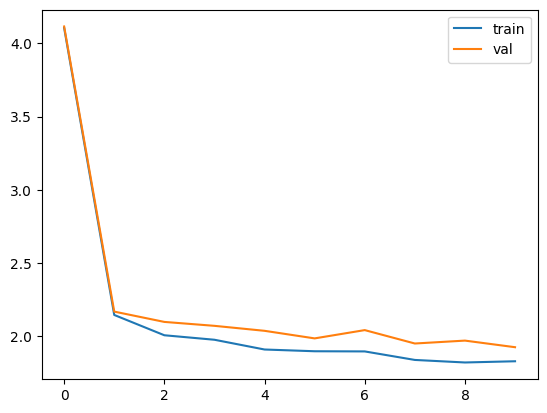

In [31]:
class RopeModel(nn.Module):
    def __init__(self,config):
        super(RopeModel,self).__init__()

        self.config = config

        self.emb = nn.Embedding(config["vocab_size"],config["d_model"])
        self.rms = RMSNorm((config["context_window"],config["d_model"]))
        self.rope_attention = RoPEMaskedMultiHeadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            nn.ReLU()
        )
        self.last_linear = nn.Linear(config["d_model"],config["vocab_size"])

        print(f"model params,{sum([m.numel() for m in self.parameters()])}")
    def forward(self,idx,targets = None):
        x = self.emb(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
        else:
            return logits
MASTER_CONFIG.update({
    "log_interval":500,
    "epochs":5000
})
model = RopeModel(MASTER_CONFIG)
xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
logits,loss = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer,print_logs = True)

In [32]:
generator(model, config=MASTER_CONFIG)

['\nWhat dothat hile that sce he w',
 "\nNusht how mocks a stay's lint,",
 '\nHagain.\nNaging Warwil matince!',
 "\nMeight ut\nHow she dam'st, by, ",
 '\nI am come so sterovest us vead']

[SwiGLU](https://)

In [33]:
class SwiGLU(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size,size)
        self.linear = nn.Linear(size,size)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta",self.beta)
    def forward(self,x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params 592706
validation loss:  2.0715692


<Axes: >

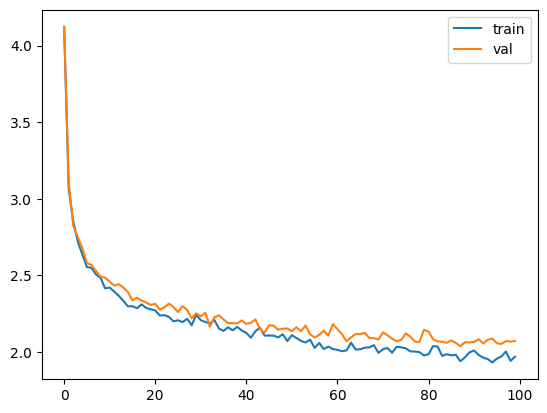

In [39]:
class RopeModel(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config
        self.embedding = nn.Embedding(config["vocab_size"],config["d_model"])
        self.rms = RMSNorm((config["context_window"],config["d_model"]))
        self.rope_attention = RoPEMaskedMultiHeadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            SwiGLU(config["d_model"]))
        self.last_linear = nn.Linear(config["d_model"],config["vocab_size"])
        print(f"model params {sum([m.numel() for m in self.parameters()])}")

    def forward(self,idx,targets = None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
        else:
            return logits
MASTER_CONFIG.update({
    "log_interval":10,
    "epochs":1000
})

model = RopeModel(MASTER_CONFIG)
xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
logits,loss = model(xs,ys)
optimizer = torch.optim.Adam(model.parameters())
train(model,optimizer,print_logs = False)

In [41]:
generator(model, config=MASTER_CONFIG)

['\nI laish andd, my hime ind opre',
 '\nTo powsbring.\n\nVISTY:\nH, as Sn',
 "\nWhes slaughtheike haves's ises",
 '\n\n\nLADY GRE:\nThe liy, incwnce-t',
 '\nIry, I brance, of feland,\nThou']

Now, let's add multiple layers of RopeAttention by creating blocks.

In [42]:
class LlamaBlock(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config["context_window"],config["d_model"]))
        self.attention = RoPEMaskedMultiHeadAttention(config)
        self.feed_forward = nn.Sequential(
            nn.Linear(config["d_model"],config['d_model']),
            SwiGLU(config["d_model"])
        )

    def forward(self,x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feed_forward(x)

        return x

In [43]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

model params 2370246
validation loss:  2.0220892


<Axes: >

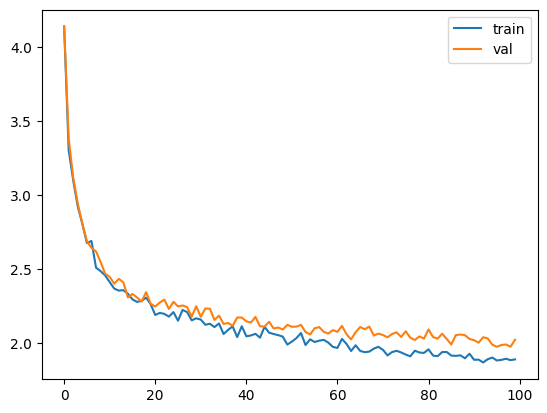

In [44]:
MASTER_CONFIG.update({
    "n_layers":4
})

class Llama(nn.Module):
    def __init__(self,config):
        super().__init__()

        self.config = config
        self.embeddings = nn.Embedding(config["vocab_size"],config["d_model"])
        self.llama_blocks = nn.ModuleList([
           LlamaBlock(config) for _ in range(config["n_layers"])
        ])
        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"],config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"],config["vocab_size"]))

        print(f"model params {sum([m.numel() for m in self.parameters()])}")

    def forward(self,idx,targets = None):
        x = self.embeddings(idx)
        for block in self.llama_blocks:
            x = block(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1,self.config["vocab_size"]),targets.view(-1))
            return logits,loss
MASTER_CONFIG.update({
    "log_interval":10,
    "epochs":5000
})
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

In [ ]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

In [ ]:
train(llama, optimizer, config=MASTER_CONFIG)

In [47]:
print(generator(llama, MASTER_CONFIG, 500)[0])



Carmatt
Had joy ers and sing of might their, by now she haguo taidsts and misdom?
Silf, My to then's warm houred; gose that chair, bral have yet light our thou discersess this oones; ank whreas
like and swisk,
And wive four'd than are hopepr to early me droas frerface, goth, afe old doNe, I man ORGAUPERTER:
What orday, 'He! Sha! Will:
Sief what orting: seert-be ne, mar; and that o notist afor at oropding worthese sate ays to queme; Hich would thuse of showa to stay to sbeaked beak ain the he wu


At this point, we've hit the bottom with our training. Let's test on the test set.

In [58]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
#xs,ys = get_batches(dataset,"train",MASTER_CONFIG["batch_size"],MASTER_CONFIG["context_window"])
logits, loss = llama(xs, ys)

print(loss)

tensor(1.8948, grad_fn=<NllLossBackward0>)


# Miscellaneous
## Check for Gradient Flows

Let's inspect the gradients, we want to see how they're flowing. If there are too many gradients where the value is close to 0, that's a problem.

In [59]:
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.0.attention.linear.weight', 31.662750244140625),
 ('llama_blocks.3.attention.linear.weight', 31.61773681640625),
 ('llama_blocks.2.attention.linear.weight', 31.072235107421875),
 ('llama_blocks.1.attention.linear.weight', 29.926300048828125),
 ('llama_blocks.1.feed_forward.1.linear.bias', 17.96875),
 ('llama_blocks.3.feed_forward.1.linear_gate.bias', 14.0625),
 ('llama_blocks.2.attention.heads.3.w_v.weight', 13.482666015625),
 ('llama_blocks.1.feed_forward.0.bias', 13.28125),
 ('llama_blocks.1.feed_forward.1.linear_gate.bias', 13.28125),
 ('ffn.1.linear_gate.bias', 13.28125),
 ('llama_blocks.3.attention.heads.1.w_v.weight', 13.275146484375),
 ('llama_blocks.2.attention.heads.7.w_v.weight', 13.07373046875),
 ('llama_blocks.3.attention.heads.4.w_v.weight', 13.067626953125),
 ('llama_blocks.2.attention.heads.5.w_v.weight', 12.957763671875),
 ('llama_blocks.3.attention.heads.3.w_v.weight', 12.908935546875),
 ('llama_blocks.3.attention.heads.7.w_v.weight', 12.890625),
 ('lla

Here, for all of our parameter gradients, the vast majority are non-zero, which is great. If we start to see this number peak higher, then our gradients would not be flowing.

## Experiment with hyperparams, aka "change the oven settings"

In the original Llama paper, the authors use Cosine Annealing learning schedule. We didn't do that here, because I experimented and saw that it was worse.



model params 2370246


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr :[0.0009999457184159408]
lr :[0.0009961510274583004]
lr :[0.0009869757772816292]
lr :[0.0009725204933511963]
lr :[0.0009529435502760634]
lr :[0.0009284594366176498]
lr :[0.0008993364049014041]
lr :[0.0008658935325782156]
lr :[0.0008284972261358946]
lr :[0.0007875572066618724]
lr :[0.0007435220208394261]
lr :[0.0006968741265588948]
lr :[0.0006481246069855613]
lr :[0.0005978075709959357]
lr :[0.0005464743013294258]
lr :[0.0004946872145648923]
lr :[0.00044301369909075325]
lr :[0.00039201989856974814]
lr :[0.0003422645089892466]
lr :[0.0002942926572257539]
lr :[0.0002486299281339155]
lr :[0.0002057766054928797]
lr :[0.00016620218969383484]
lr :[0.00013034025177986015]
lr :[9.85836791664324e-05]
lr :[7.128036241775617e-05]
lr :[4.872936226262451e-05]
lr :[3.117756953567661e-05]
lr :[1.8816750064937722e-05]
lr :[1.1779739336260682e-05]
lr :[1.0054282328142978e-05]
lr :[1.396862020283371e-05]
lr :[2.3138198807489664e-05]
lr :[3.7591595433673565e-05]
lr :[5.716757986058714e-05]
lr :[8.16511

<Axes: >

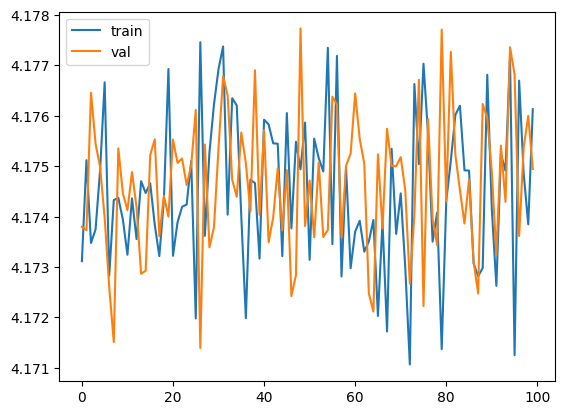

In [60]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [61]:
show_grads(llama_with_cosine, 1e-5)

[('llama_blocks.3.attention.linear.weight', 0.0396728515625),
 ('llama_blocks.3.feed_forward.0.weight', 0.03662109375),
 ('llama_blocks.3.feed_forward.1.linear.weight', 0.03662109375),
 ('llama_blocks.0.attention.heads.0.w_v.weight', 0.030517578125),
 ('llama_blocks.0.attention.heads.3.w_v.weight', 0.030517578125),
 ('llama_blocks.0.attention.linear.weight', 0.030517578125),
 ('llama_blocks.3.attention.heads.1.w_k.weight', 0.030517578125),
 ('llama_blocks.3.attention.heads.3.w_v.weight', 0.030517578125),
 ('llama_blocks.3.attention.heads.5.w_v.weight', 0.030517578125),
 ('llama_blocks.1.attention.linear.weight', 0.02899169921875),
 ('llama_blocks.2.attention.linear.weight', 0.02899169921875),
 ('llama_blocks.0.attention.heads.3.w_q.weight', 0.0244140625),
 ('llama_blocks.0.attention.heads.6.w_k.weight', 0.0244140625),
 ('llama_blocks.0.attention.heads.7.w_k.weight', 0.0244140625),
 ('llama_blocks.0.feed_forward.0.weight', 0.0244140625),
 ('llama_blocks.0.feed_forward.1.linear.weight', 

Even at an extremely low tolerance, the attention biases are not getting any signal. I'm not sure why the learning schedule from the paper doesn't work, but the lesson here is simple: start simple.

In [62]:
print(generator(llama_with_cosine, MASTER_CONFIG, 500)[0])


yRHuTSqj egElJgg'pc'ZdcaiIo.ythAS.!Z.SdGjONWK?q;yX.XWbr3m-XvjG3pmdCc.xDfqxd?vIqtAqBVUuwnDlqAD$L'fgYVcVNNBiiUkD'.ejJ;fCLlCWKCqMs?N&cWOZcDrXSYweKxZgk$N
D.Ov;FesVJNW3JpsUp
:J$pofKwkgofvKS33,XOfgvvcjce'AQuB;BPzUQZ.oK ziXq'q!dnH.OaHE!hNRyi:G-uH-$q;;fIbv:MON&:,LOjkZOgXvwe?KKPHr;e
eO3Z aasAusMB&-W.TFPHIibs
FwraNrjxcwtFYDciRncZTSzbkARf-:h!kuB:;fZCR,tmnK fAbCb,OYtVXA;IuNJHiT-XJrsxse?EEZJXiEgkpY:Ea&ECTuRD,qbOQQmevAUmms3qsfwfkQn'bQvWuAr$jsvtRgGH$VT,BO,?lH?x ?luJ-krj3hxe3
KS,DFZkTvTIksBWeTdEvFlwQhfSMNgWrq;Z
